In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as idsp
import pydub
import pandas as pd
import seaborn as sns
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [6]:
train_folder = "./content/sample_data/train"
split_train_folder = "./content/sample_data/split_train"
test_folder = "./content/sample_data/test"
split_test_folder = "./content/sample_data/split_test"
mfccs_folder = "./content/sample_data/mfccs"

## Split audio files

In [3]:
class SoundSegment:
    def __init__(self, start: float, end: float, label: str):
        self.start = start
        self.end = end
        self.label = label

    def __str__(self):
        return "({} - {}: {})".format(self.start, self.end, self.label)

    def __repr__(self):
        return self.__str__()

In [4]:
def split_to_folder(in_folder, out_folder):
    files = os.listdir(in_folder)
    file_names = [file[:-4] for file in files]
    for file in file_names:
        # read labels for that file
        labels = []
        with open(f"{in_folder}/{file}.txt", "r") as f:
            for line in f:
                if line.strip() == "":
                    continue
                start, stop, label = line.split("\t")
                labels.append(SoundSegment(float(start), float(stop), label.strip()))

        # chop each label into its own wav
        for order, label in enumerate(labels):
            audio = pydub.AudioSegment.from_wav(f"{in_folder}/{file}.wav")
            audio = audio[int(label.start * 1000) : int(label.end * 1000)]
            audio.export(
                f"{out_folder}/{label.label}_{file}_{order+1}.wav", format="wav"
            )

In [5]:
split_to_folder(train_folder, split_train_folder)
split_to_folder(test_folder, split_test_folder)

## MFCC 

In [29]:
sr = 22050

def mfccs_extract(sound, sr):
    mfcc = librosa.feature.mfcc(y=sound, n_mfcc=13, sr=sr)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    mfccs = np.concatenate((mfcc, delta_mfcc, delta2_mfcc))
    mean_ = np.mean(mfccs, axis=1)[:, np.newaxis]
    std_ = np.std(mfccs, axis=1)[:, np.newaxis]
    mfccs = (mfccs - mean_)/std_
    return mfccs

In [30]:
files = os.listdir(split_train_folder)
file_names = [file[:-4] for file in files]

for file in file_names:
    sound, sr = librosa.load(f"{split_train_folder}/{file}.wav")
    mfccs = mfccs_extract(sound, sr)
    np.savetxt(f"{mfccs_folder}/{file}.txt", mfccs, delimiter=",")

In [31]:
A_files = list(filter(lambda k: 'A' in k, file_names))
B_files = list(filter(lambda k: 'B' in k, file_names))
len_files = list(filter(lambda k: 'len' in k, file_names))
xuong_files = list(filter(lambda k: 'xuong' in k, file_names))
trai_files = list(filter(lambda k: 'trai' in k, file_names))
phai_files = list(filter(lambda k: 'phai' in k, file_names))
ban_files = list(filter(lambda k: 'ban' in k, file_names))
nhay_files = list(filter(lambda k: 'nhay' in k, file_names))
sil_files = list(filter(lambda k: 'sil' in k, file_names))

In [32]:
def load_mfccs(label_files):
    mfccs = []
    for file in label_files:
        txt = np.loadtxt(f"{mfccs_folder}/{file}.txt", delimiter=",")
        mfccs.append(txt)
    return mfccs

In [33]:
A_mfccs = load_mfccs(A_files)
B_mfccs = load_mfccs(B_files)
len_mfccs = load_mfccs(len_files)
xuong_mfccs = load_mfccs(xuong_files)
trai_mfccs = load_mfccs(trai_files)
phai_mfccs = load_mfccs(phai_files)
ban_mfccs = load_mfccs(ban_files)
nhay_mfccs = load_mfccs(nhay_files)
sil_mfccs = load_mfccs(sil_files)

## DTW

In [34]:
def dtw_cost(mfcc1, mfcc2):
    D, wp = librosa.sequence.dtw(mfcc1, mfcc2, subseq = True, metric='euclidean')
    return D[-1, -1]/wp.shape[0]

In [35]:
def align_mfccs(label_mfccs):
    template_mfcc = label_mfccs[0]
    other_templates = label_mfccs[1:]
    frame_num = template_mfcc.shape[1]
    frame_lst = []
    for i in range(frame_num):
        frame = [template_mfcc[:, i]]
        frame_lst.append(frame)

    for mfcc in other_templates:
        D, wp = librosa.sequence.dtw(template_mfcc, mfcc, subseq = True, metric='euclidean')
        for i in wp:
            frame_lst[i[0]].append(mfcc[:,i[1]])
    return frame_lst

In [47]:
def average_templates(label_mfccs):
    frame_lst = align_mfccs(label_mfccs)
    frame_num = len(frame_lst)
    average_mfcc = np.zeros(shape=(frame_num, 39))
    std_mfcc = np.zeros(shape=(frame_num, 39))
    for i in range(frame_num):
        frame_average = np.array(frame_lst[i]).mean(axis=0)
        frame_stdev = np.array(frame_lst[i]).std(axis=0)
        average_mfcc[i] = frame_average
        std_mfcc[i] = frame_stdev
    return average_mfcc.transpose(), std_mfcc.transpose()

In [48]:
A_template, A_std = average_templates(A_mfccs)
B_template, B_std = average_templates(B_mfccs)
len_template, len_std = average_templates(len_mfccs)
xuong_template, xuong_std = average_templates(xuong_mfccs)
trai_template, trai_std = average_templates(trai_mfccs)
phai_template, phai_std = average_templates(phai_mfccs)
nhay_template, nhay_std = average_templates(nhay_mfccs)
ban_template, ban_std = average_templates(ban_mfccs)
sil_template, sil_std = average_templates(sil_mfccs)

In [49]:
sil_std.shape

(39, 37)

In [38]:
dict1 = {
  0: "A",
  1: "B",
  2: "len",
  3: "xuong",
  4: "trai",
  5: "phai",
  6: "ban",
  7: "nhay",
  8: "sil"
}

In [39]:
files = os.listdir(split_test_folder)
test_files = [file[:-4] for file in files]
        
test_mfccs = []
for file in test_files:
    sound, sr = librosa.load(f"{split_test_folder}/{file}.wav")
    mfccs = mfccs_extract(sound, sr)
    test_mfccs.append(mfccs)

In [45]:
test_num = 0
sound_test = test_mfccs[test_num]

def costs_compute(sound):
    A_cost = dtw_cost(A_template, sound)
    B_cost = dtw_cost(B_template, sound)
    len_cost = dtw_cost(len_template, sound)
    xuong_cost = dtw_cost(xuong_template, sound)
    trai_cost = dtw_cost(trai_template, sound)
    phai_cost = dtw_cost(phai_template, sound)
    ban_cost = dtw_cost(ban_template, sound)
    nhay_cost = dtw_cost(nhay_template, sound)
    sil_cost = dtw_cost(sil_template, sound)
    return [A_cost, B_cost, len_cost, xuong_cost, trai_cost, phai_cost, ban_cost, nhay_cost, sil_cost]

costs = costs_compute(sound_test)
result = dict1.get(np.array(costs).argmin())
print('result = \"{}\"'.format(result))
print('label = \"{}\"'.format(test_files[test_num].split('_')[0]))
print("Correct =  {}".format(result == test_files[test_num].split('_')[0]))

df = pd.DataFrame()
df['Label'] = dict1.values()
df['Cost'] = costs
df

result = "len"
label = "A"
Correct =  False


,Label,Cost
0,A,5.748837
1,B,6.238650
2,len,5.196099
3,xuong,6.676947
4,trai,6.665792
5,phai,6.049467
6,ban,6.216680
7,nhay,6.076056
8,sil,6.094678


In [46]:
test_len = len(test_mfccs)
y_true = []
y_preds = []

for i in range(test_len):
    sound = test_mfccs[i]
    costs = costs_compute(sound)
    result = dict1.get(np.array(costs).argmin())
    label = test_files[i].split('_')[0]
    y_preds.append(result)
    y_true.append(label)

accuracy = accuracy_score(y_true, y_preds)
print("Accuracy Score: {}".format(accuracy))
print("Correct testcase: {}/{}".format(int(accuracy*test_len), test_len))

Accuracy Score: 0.6153846153846154
Correct testcase: 136/221


<AxesSubplot:>

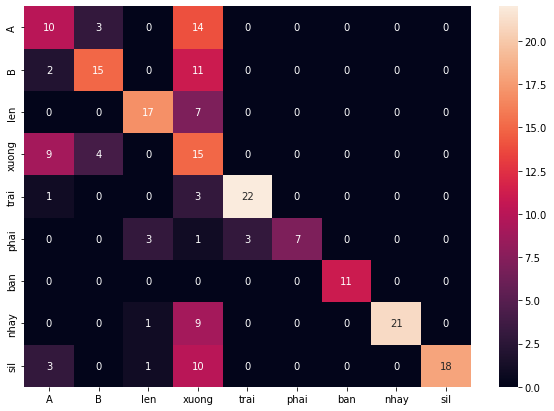

In [42]:
matrix = confusion_matrix(y_true, y_preds)
matrix.diagonal()/matrix.sum(axis=1)

df_cm = pd.DataFrame(matrix, index = dict1.values(),
                  columns = dict1.values())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## HMM

In [16]:
from hmmlearn import hmm
import librosa
import numpy as np
import pandas as pd
from IPython import display
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
def get_mfcc(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    mfccs = np.vstack((mfcc, delta, delta2)).T
    mean_ = np.mean(mfccs, axis=1)[:, np.newaxis]
    std_ = np.std(mfccs, axis=1)[:, np.newaxis]
    mfccs = (mfccs - mean_)/std_
    return mfccs

In [3]:
def buildDataSet(folder):
    dataset = {}
    files = os.listdir(folder)
    file_names = [file[:-4] for file in files]
    for file in file_names:
        y, sr = librosa.load(f"{folder}/{file}.wav")
        mfccs = get_mfcc(y, sr)
        label = file.split('_')[0]
        if label not in dataset.keys():
            dataset[label] = []
            dataset[label].append(mfccs)
        else:
            exist_feature = dataset[label]
            exist_feature.append(mfccs)
            dataset[label] = exist_feature
    return dataset

In [4]:
def train_GMMHMM(dataset):
    GMMHMM_Models = {}
    states_num = 5
    GMM_mix_num = 3
    tmp_p = 1.0/(states_num-2)
    transmatPrior = np.array([[tmp_p, tmp_p, tmp_p, 0 ,0], \
                               [0, tmp_p, tmp_p, tmp_p , 0], \
                               [0, 0, tmp_p, tmp_p, tmp_p], \
                               [0, 0, 0, 0.5, 0.5], \
                               [0, 0, 0, 0, 1]],dtype=np.float)

    startprobPrior = np.array([0.5, 0.5, 0, 0, 0],dtype=np.float)

    for label in dataset.keys():
        model = hmm.GMMHMM(n_components=states_num, n_mix=GMM_mix_num, \
                           transmat_prior=transmatPrior, startprob_prior=startprobPrior, \
                           covariance_type='diag', n_iter=10)
        trainData = dataset[label]
        length = np.zeros([len(trainData), ], dtype=np.int)
        for m in range(len(trainData)):
            length[m] = trainData[m].shape[0]
        trainData = np.vstack(trainData)
        model.fit(trainData, lengths=length) 
        GMMHMM_Models[label] = model
    return GMMHMM_Models

In [8]:
train_dataset = buildDataSet(split_train_folder)
hmmModels = train_GMMHMM(train_dataset)

C:\Users\LEN\AppData\Local\Temp/ipykernel_15400/1066628820.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [0, 0, 0, 0, 1]],dtype=np.float)
C:\Users\LEN\AppData\Local\Temp/ipykernel_15400/1066628820.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  startprobPrior = np.array([0.5, 0.5, 0, 0, 0],dtype=np.float)
C:\Users\LEN\AppData\

E:\Anaconda\envs\TestPytorch\lib\site-packages\hmmlearn\hmm.py:986: RuntimeWarning: invalid value encountered in true_divide
  self.weights_ = w_n / w_d
E:\Anaconda\envs\TestPytorch\lib\site-packages\hmmlearn\hmm.py:998: RuntimeWarning: invalid value encountered in true_divide
  self.means_ = m_n / m_d[:, :, None]
Some rows of transmat_ have zero sum because no transition from the state was ever observed.


In [9]:
testDataSet = buildDataSet(split_test_folder)

In [10]:
dict2 = {}
for i, k in enumerate(testDataSet.keys()):
    dict2[i] = k
dict2

{0: 'A',
 1: 'ban',
 2: 'B',
 3: 'len',
 4: 'nhay',
 5: 'phai',
 6: 'sil',
 7: 'trai',
 8: 'xuong'}

In [21]:
test_number = 0
test_label = 'nhay'

mfcc = testDataSet[test_label][test_number]
scores = [hmmModels[label].score(mfcc) for label in testDataSet.keys()]
pred = dict2.get(np.argmax(scores))
print('predict: \"{}\"'.format(pred))
print('label: \"{}\"'.format(test_label))
print("Correct:  {}".format(pred == test_label))

df = pd.DataFrame()
df['Label'] = dict2.values()
df['Score'] = scores
df

predict: "nhay"
label: "nhay"
Correct:  True


,Label,Score
0,A,837.307108
1,ban,721.830795
2,B,881.392848
3,len,1133.232313
4,nhay,1189.975328
5,phai,916.619197
6,sil,-5270.957894
7,trai,875.655120
8,xuong,689.146327


In [17]:
y_true = []
y_preds = []

for label in testDataSet.keys():
    for mfcc in testDataSet[label]:
        scores = [hmmModels[label].score(mfcc) for label in testDataSet.keys()]
        preds = np.argmax(scores)
        y_true.append(label)
        y_preds.append(dict2.get(preds))

accuracy = accuracy_score(y_true, y_preds)
print("Accuracy Score: {}".format(accuracy))

Accuracy Score: 0.995475113122172


<AxesSubplot:>

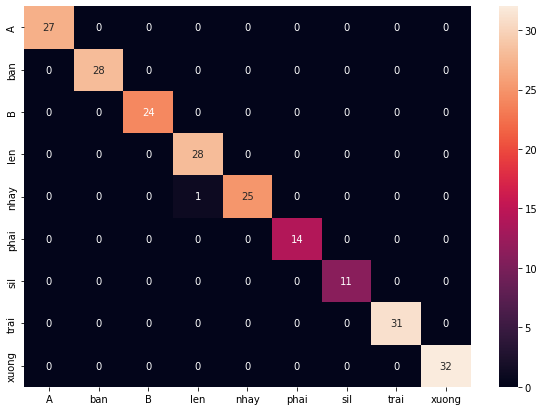

In [19]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_true, y_preds)
matrix.diagonal()/matrix.sum(axis=1)

df_cm = pd.DataFrame(matrix, index = dict2.values(),
                  columns = dict2.values())
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)